In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import wfdb
import datetime
import talos 
import seaborn as sns
import os

from sklearn.metrics import roc_curve, auc
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from kerashypetune import KerasGridSearchCV, KerasGridSearch

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
print(tf.__version__)
seed = 42
# test

2.6.0


# Setup and load processed data

In [2]:
#RR_INTERVALS_INTERPOLATION 240
sequence_length = 240
FS = 100.0

In [3]:
def z_norm(result):
    result_mean = np.mean(result)
    result_std = np.std(result)
    result = (result - result_mean) / result_std
    return result

def split_data(X):
    X1 = []
    X2 = []
    for index in range(len(X)):
        X1.append([X[index][0], X[index][1]])
        X2.append([X[index][2], X[index][3]])

    return np.array(X1).astype('float64'), np.array(X2).astype('float64')


In [4]:
def get_data():
    X_train = np.load('new_train_input.npy', allow_pickle=True)
    y_train = np.load('new_train_label.npy', allow_pickle=True)

    X_test = np.load('new_test_input.npy', allow_pickle=True)
    y_test = np.load('new_test_label.npy', allow_pickle=True)
    print("X_train: ", X_train.shape)
    
    # # Load SAD dataset
    # X_test_sad = np.load('spaches_test.npy', allow_pickle=True)
    # y_test_sad = np.load('spaches_test_label.npy', allow_pickle=True)
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    '''
    X_train = X_train[:, 0, :]
    X_test = X_test[:, 0, :]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    '''
    #X_train1 shape (number_of_independent_sequences, length_or_steps_of_a_sequence, variables_or_features_per_step)
    X_train1, X_train2 = split_data(X_train)
    X_test1, X_test2 = split_data(X_test)

    print("X_train1: ", X_train1.shape)
    
    X_train1 = np.transpose(X_train1, (0, 2, 1))
    print("X_train1 transpose: ", X_train1.shape)
  
    X_train2 = np.reshape(X_train2, (X_train2.shape[0], X_train2.shape[1], 1))
    print("X_train2: ", X_train2.shape)
   
    X_test1 = np.transpose(X_test1, (0, 2, 1))
   
    X_test2 = np.reshape(X_test2, (X_test2.shape[0], X_test2.shape[1], 1))

    return X_train1, X_train2, y_train, X_test1, X_test2, y_test

In [5]:
#---------------Shuffle data--------------------------
X_train1, X_train2, y_train, X_test1, X_test2, y_test = get_data()
print (X_train1.shape)
print (X_train2.shape)
print (X_test1.shape)
print (X_test2.shape)
print (y_train.shape)
print (y_test.shape)
print (X_train2)

X_train:  (28233, 4)
X_train1:  (28233, 2, 240)
X_train1 transpose:  (28233, 240, 2)
X_train2:  (28233, 2, 1)
(28233, 240, 2)
(28233, 2, 1)
(4960, 240, 2)
(4960, 2, 1)
(28233,)
(4960,)
[[[51.]
  [ 1.]]

 [[51.]
  [ 1.]]

 [[51.]
  [ 1.]]

 ...

 [[55.]
  [ 1.]]

 [[55.]
  [ 1.]]

 [[55.]
  [ 1.]]]


In [6]:
## join X_train1 and X_test1, X_train2 and X_test2, y_train and y_test,
X_tmp1 = np.concatenate((X_train1, X_test1), axis = 0)
X_tmp2 = np.concatenate((X_train2, X_test2), axis = 0)
Y_tmp = np.concatenate((y_train, y_test), axis = 0)
print(X_tmp1.shape)
print(X_tmp2.shape)
print(Y_tmp.shape)

(33193, 240, 2)
(33193, 2, 1)
(33193,)


# Test with SAD dataset

In [7]:
## then use train_test_split to shuffe data
X_train1, X_test1, y_train, y_test = train_test_split(X_tmp1, Y_tmp, test_size=0.1, random_state=42, shuffle=True)
print(X_train1.shape)
# print(X_train)
print(y_train.shape)
# print(y_train)
print(X_test1.shape)
# print(X_test1)
print(y_test.shape)


(29873, 240, 2)
(29873,)
(3320, 240, 2)
(3320,)


In [8]:
X_train2, X_test2, y_train, y_test = train_test_split(X_tmp2, Y_tmp, test_size=0.1, random_state=42, shuffle=True)
print(X_train2.shape)
# print(X_train2)
print(X_test2.shape)
print(y_train.shape)
# print(y_train)
#--------------close shuffle data--------------------------------

(29873, 2, 1)
(3320, 2, 1)
(29873,)


# Perform hyper parameter tuning with cross validation

In [10]:
def get_model(param):
    # The number of hidden units is a direct representation of the learning capacity of a neural network -- it reflects the number of learned parameters. 
    # The value 256 was selected arbitrarily or empirically 
    layers = {'input': 2, 'hidden1': param['unit'], 'hidden2': param['unit'], 'hidden3': param['unit'], 'output': 1}
    # sequence_length is the timestep (Tx) ( a 1' window)
    #The `Input()` layer is used for defining the input `X` as well as the initial hidden state 'a0' and cell state `c0`.
    #The `shape` parameter takes a tuple that does not include the batch dimension (`m`).
    #Samples. One sequence is one sample. A batch is comprised of one or more samples.
    #Time Steps. One time step is one point of observation in the sample.
    #Features. One feature is one observation at a time step.
    #shape=(240,2) indicates that the expected input will be batches of 240-dimensional vectors, and 2 input features (RRI + R-peak amplitude)
    x1 = tf.keras.layers.Input(shape=(sequence_length, layers['input']))
    
    #units (256)- dimensionality of the output space.
    #fraction of the units to drop for the linear transformation of the recurrent state = 0.5
    # return sequences return the hidden state output for each input time step (many-to-many)
    m1 = tf.keras.layers.LSTM(layers['hidden1'],
                              use_bias=True,
                              dropout=param['dr1'],
                    recurrent_dropout=0,
                   return_sequences=True)(x1)
    m1 = tf.keras.layers.LSTM(
            layers['hidden2'],
            use_bias=True,
            dropout=param['dr2'],
            recurrent_dropout=0,
            return_sequences=True)(m1)

    m1 = tf.keras.layers.LSTM(
            layers['hidden3'],
            use_bias=True,
            dropout=param['dr3'],
            recurrent_dropout=0,
            return_sequences=False)(m1)

    m1 = tf.keras.layers.Dense(128)(m1)
    m1 = tf.keras.layers.Dense(64)(m1)
    m1 = tf.keras.layers.Dense(32)(m1)
    
    x2 = tf.keras.layers.Input(shape=(2,))
    m2 = tf.keras.layers.Dense(128)(x2)
    m2 = tf.keras.layers.Dense(64)(m2) 
    m2 = tf.keras.layers.Dense(32)(m2)
    
    merged = tf.keras.layers.Concatenate(axis=1)([m1, m2])

    out = tf.keras.layers.Dense(8)(merged)
    out = tf.keras.layers.Dense(layers['output'], kernel_initializer='normal')(out)
    out = tf.keras.layers.Activation("sigmoid")(out)
    
    model = tf.keras.models.Model(inputs=[x1, x2], outputs=[out])

    start = time.time()
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=param['lr']), metrics="accuracy")
    print ("Compilation Time : ", time.time() - start)
    
    #he None dimension in the shape tuple refers to the batch dimension which simply means that the layer can accept input of any size.
    # plot_model(model, to_file='model_plot_quoc.png', show_shapes=True, show_layer_names=True)
    model.summary()
    return model

## Test on baseline models

In [11]:
# https://keras.io/api/layers/recurrent_layers/lstm/
model_params = {
    # 'rnn': {
    #     'model': svm.SVC(gamma='auto'),
    #     'params' : {
    #         'C': [1,10,20],
    #         'kernel': ['rbf','linear']
    #     }  
    # },
    # 'gru': {
    #     'model': RandomForestClassifier(),
    #     'params' : {
    #         'n_estimators': [1,5,10]
    #     }
    # },
    # 'cnn': {
    #     'model': cnn(),
    #     'params' : {
    #       'unit': [256, 384],
    #       'lr': [1e-2, 1e-3],
    #      'activ': ['elu','relu'],
    #      'epochs': 50,
    #      'batch_size': 64
    #     }  
    # },
    'our_model': {
        'model': get_model,
        'params': {
            'dr1': [0.1, 0.2],
            'dr2': [0.1, 0.2],
            'dr3': [0.1, 0.2],
            'unit': [256, 384],
            'lr': [1e-2, 1e-3],
            # 'activ': ['elu','relu'],
            'epochs': 50,
            'batch_size': 64
        }
    }
}

In [12]:
cv = KFold(n_splits=5, random_state=33, shuffle=True)

In [13]:
 # greater_is_better : bool, default=False
 #        Whether the quantity to monitor is a score function, meaning high
 #        is good, or a loss function (as default), meaning low is good.
scores = []
log_dir = "logs/hp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
mc = ModelCheckpoint('hyper_tuning.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

for model_name, mp in model_params.items():
    kgs = KerasGridSearchCV(mp['model'], mp['params'], cv=cv, monitor='val_accuracy', greater_is_better=True)
    kgs.search([X_train1,X_train2], y_train, callbacks=[tensorboard_callback, mc])
    scores.append({
        'model': model_name,
        'best_score': kgs.folds_best_score,
        'best_params': kgs.folds_best_params
    })
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df


##################
###  Fold 001  ###
##################

32 trials detected for ('dr1', 'dr2', 'dr3', 'unit', 'lr', 'epochs', 'batch_size')
Compilation Time :  0.008445978164672852
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 2)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 240, 256)     265216      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 240, 256)     525312      lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LS

,model,best_score,best_params
0,our_model,"{'fold 1': 0.86828, 'fold 2': 0.86728, 'fold 3': 0.8723, 'fold 4': 0.86173, 'fold 5': 0.86374}","{'fold 1': {'dr1': 0.1, 'dr2': 0.1, 'dr3': 0.2, 'unit': 384, 'lr': 0.001, 'epochs': 44, 'batch_size': 64, 'steps_per_epoch': 374}, 'fold 2': {'dr1': 0.1, 'dr2': 0.1, 'dr3': 0.2, 'unit': 384, 'lr': 0.001, 'epochs': 38, 'batch_size': 64, 'steps_per_epoch': 374}, 'fold 3': {'dr1': 0.1, 'dr2': 0.2, 'dr3': 0.1, 'unit': 384, 'lr': 0.001, 'epochs': 41, 'batch_size': 64, 'steps_per_epoch': 374}, 'fold 4': {'dr1': 0.1, 'dr2': 0.1, 'dr3': 0.1, 'unit': 256, 'lr': 0.001, 'epochs': 30, 'batch_size': 64, 'steps_per_epoch': 374}, 'fold 5': {'dr1': 0.1, 'dr2': 0.1, 'dr3': 0.1, 'unit': 256, 'lr': 0.001, 'epochs': 32, 'batch_size': 64, 'steps_per_epoch': 374}}"


In [14]:
kgs.folds_best_params

{'fold 1': {'dr1': 0.1,
  'dr2': 0.1,
  'dr3': 0.2,
  'unit': 384,
  'lr': 0.001,
  'epochs': 44,
  'batch_size': 64,
  'steps_per_epoch': 374},
 'fold 2': {'dr1': 0.1,
  'dr2': 0.1,
  'dr3': 0.2,
  'unit': 384,
  'lr': 0.001,
  'epochs': 38,
  'batch_size': 64,
  'steps_per_epoch': 374},
 'fold 3': {'dr1': 0.1,
  'dr2': 0.2,
  'dr3': 0.1,
  'unit': 384,
  'lr': 0.001,
  'epochs': 41,
  'batch_size': 64,
  'steps_per_epoch': 374},
 'fold 4': {'dr1': 0.1,
  'dr2': 0.1,
  'dr3': 0.1,
  'unit': 256,
  'lr': 0.001,
  'epochs': 30,
  'batch_size': 64,
  'steps_per_epoch': 374},
 'fold 5': {'dr1': 0.1,
  'dr2': 0.1,
  'dr3': 0.1,
  'unit': 256,
  'lr': 0.001,
  'epochs': 32,
  'batch_size': 64,
  'steps_per_epoch': 374}}

#### kgs.folds_best_score

# Re-train with the best hyper-paremeters and test on the val-set

## Model Architecture

In [77]:
epochs = int(input('Enter Number of Epochs (or enter default 1000): '))

Enter Number of Epochs (or enter default 1000):  8


In [78]:
def build_model():
    # The number of hidden units is a direct representation of the learning capacity of a neural network -- it reflects the number of learned parameters. 
    # The value 256 was selected arbitrarily or empirically 
    layers = {'input': 2, 'hidden1': 378, 'hidden2': 378, 'hidden3':378, 'output': 1}
    # sequence_length is the timestep (Tx) ( a 1' window)
    #The `Input()` layer is used for defining the input `X` as well as the initial hidden state 'a0' and cell state `c0`.
    #The `shape` parameter takes a tuple that does not include the batch dimension (`m`).
    #Samples. One sequence is one sample. A batch is comprised of one or more samples.
    #Time Steps. One time step is one point of observation in the sample.
    #Features. One feature is one observation at a time step.
    #shape=(240,2) indicates that the expected input will be batches of 240-dimensional vectors, and 2 input features (RRI + R-peak amplitude)
    x1 = tf.keras.layers.Input(shape=(sequence_length, layers['input']))
    
    #units (256)- dimensionality of the output space.
    #fraction of the units to drop for the linear transformation of the recurrent state = 0.5
    # return sequences return the hidden state output for each input time step (many-to-many)
    m1 = tf.keras.layers.LSTM(layers['hidden1'],
                              use_bias=True,
                              dropout=0.1,
                    recurrent_dropout=0,
                   return_sequences=True)(x1)
    m1 = tf.keras.layers.LSTM(
            layers['hidden2'],
            use_bias=True,
            dropout=0.2,
            recurrent_dropout=0,
            return_sequences=True)(m1)

    m1 = tf.keras.layers.LSTM(
            layers['hidden3'],
            use_bias=True,
            dropout=0.2,
            recurrent_dropout=0,
            return_sequences=False)(m1)

    m1 = tf.keras.layers.Dense(128)(m1)
    m1 = tf.keras.layers.Dense(64)(m1)
    m1 = tf.keras.layers.Dense(32)(m1)
    
    x2 = tf.keras.layers.Input(shape=(2,))
    m2 = tf.keras.layers.Dense(128)(x2)
    m2 = tf.keras.layers.Dense(64)(m2) 
    m2 = tf.keras.layers.Dense(32)(m2)
    #merged = Merge([model1, model2], mode='concat')
    merged = tf.keras.layers.Concatenate(axis=1)([m1, m2])

    out = tf.keras.layers.Dense(8)(merged)
    out = tf.keras.layers.Dense(layers['output'], kernel_initializer='normal')(out)
    out = tf.keras.layers.Activation("sigmoid")(out)
    
    model = tf.keras.models.Model(inputs=[x1, x2], outputs=[out])

    start = time.time()
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics="accuracy")
    print ("Compilation Time : ", time.time() - start)
    
    #he None dimension in the shape tuple refers to the batch dimension which simply means that the layer can accept input of any size.
    # plot_model(model, to_file='model_plot_quoc.png', show_shapes=True, show_layer_names=True)
    
    model.summary()
    return model

In [79]:

global_start_time = time.time()

class_w = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

print (class_w)

# if model is None:
model = build_model()

try:
    print("Training")

    log_dir = "logs/hp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    # simple early stopping
    
    # es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=35)
    mc = ModelCheckpoint('hyper_tuning.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

    class_w = {i : class_w[i] for i in range(2)}
    history = model.fit([X_train1, X_train2], y_train, epochs=epochs, batch_size=64, class_weight=class_w, callbacks=[tensorboard_callback, mc])

except KeyboardInterrupt:
    print("prediction exception")
    print ('Training duration (s) : ', time.time() - global_start_time)
    # model.save("break_my_model_400.h5") 
#     return model
print ('Training duration (s) : ', time.time() - global_start_time)
# model.save("my_model_80.h5")


[0.80411844 1.32204815]
Compilation Time :  0.0023360252380371094
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 240, 2)]     0                                            
__________________________________________________________________________________________________
lstm_24 (LSTM)                  (None, 240, 378)     576072      input_17[0][0]                   
__________________________________________________________________________________________________
lstm_25 (LSTM)                  (None, 240, 378)     1144584     lstm_24[0][0]                    
__________________________________________________________________________________________________
lstm_26 (LSTM)                  (None, 378)          1144584     lstm_25[0][0]                    
__________________________

## Model evaluation

In [80]:
# Evaluate Model
y_pred = (model.predict([X_test1, X_test2]) >= 0.50).astype(int)
scores = model.evaluate([X_test1, X_test2], y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

104/104 [==============================] - 3s 20ms/step - loss: 0.3800 - accuracy: 0.8250
accuracy: 82.50%


<AxesSubplot:>

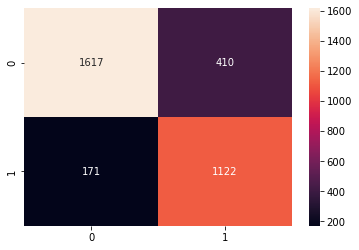

In [81]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt="d")

FPR:  (778,)
TPR:  (778,)


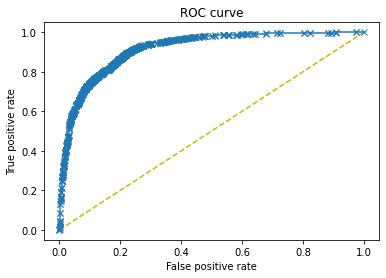

(778,)


In [82]:
y_preds = model.predict([X_test1, X_test2]).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
print("FPR: ", fpr.shape)
print("TPR: ", tpr.shape)

plt.figure(1)
plt.plot([0,1], [0,1], 'y--')
plt.plot(fpr, tpr, marker='x')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
print(thresholds.shape)

In [83]:
auc_value = auc(fpr, tpr)
auc_value

0.9161081776527322

In [84]:
# save fpr, tpr into files
with open('roc_log/sad/fpr2.npy', 'wb') as f:
    np.save(f, fpr)
with open('roc_log/sad/tpr2.npy', 'wb') as f:
    np.save(f, tpr)
with open('roc_log/sad/auc2.npy', 'wb') as f:
    np.save(f, auc_value)

In [85]:
with open('roc_log/sad/auc1.npy', 'rb') as f:
    auc1 = np.load(f)
with open('roc_log/sad/auc2.npy', 'rb') as f:
    auc2 = np.load(f)
with open('roc_log/sad/auc3.npy', 'rb') as f:
    auc3 = np.load(f)
with open('roc_log/sad/auc4.npy', 'rb') as f:
    auc4 = np.load(f)
with open('roc_log/sad/auc5.npy', 'rb') as f:
    auc5 = np.load(f)

with open('roc_log/sad/fpr1.npy', 'rb') as f:
    fpr1 = np.load(f)
with open('roc_log/sad/fpr2.npy', 'rb') as f:
    fpr2 = np.load(f)
with open('roc_log/sad/fpr3.npy', 'rb') as f:
    fpr3 = np.load(f)
with open('roc_log/sad/fpr4.npy', 'rb') as f:
    fpr4 = np.load(f)
with open('roc_log/sad/fpr5.npy', 'rb') as f:
    fpr5 = np.load(f)
    
with open('roc_log/sad/tpr1.npy', 'rb') as f:
    tpr1 = np.load(f)
with open('roc_log/sad/tpr2.npy', 'rb') as f:
    tpr2 = np.load(f)
with open('roc_log/sad/tpr3.npy', 'rb') as f:
    tpr3 = np.load(f)
with open('roc_log/sad/tpr4.npy', 'rb') as f:
    tpr4 = np.load(f)
with open('roc_log/sad/tpr5.npy', 'rb') as f:
    tpr5 = np.load(f)

In [86]:

aucs = []

aucs.append(auc1)
aucs.append(auc2)
aucs.append(auc3)
aucs.append(auc4)
aucs.append(auc5)
print(len(aucs))

5


In [87]:
# interpolate fpr , tpr to the same scale
mean_fpr = np.linspace(0, 1, 100)
tprs = []

interp_tpr = np.interp(mean_fpr, fpr1, tpr1)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)

interp_tpr = np.interp(mean_fpr, fpr2, tpr2)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)

interp_tpr = np.interp(mean_fpr, fpr3, tpr3)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)

interp_tpr = np.interp(mean_fpr, fpr4, tpr4)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)

interp_tpr = np.interp(mean_fpr, fpr5, tpr5)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)



In [88]:
print(aucs)
print(len(tprs))

[array(0.92662742), array(0.91610818), array(0.93296529), array(0.92242507), array(0.8749473)]
5


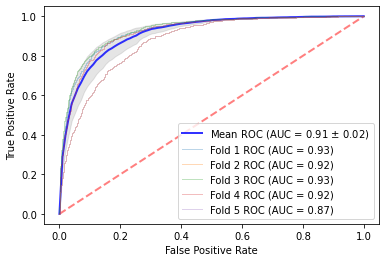

In [95]:
# fig, ax = plt.subplots()
plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="", alpha=0.5)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
    # marker='x'
)
plt.plot(
    fpr1,
    tpr1,
    
    label=r"Fold 1 ROC (AUC = %0.2f)" % (auc1),
    lw=1,
    alpha=0.3,
)
plt.plot(
    fpr5,
    tpr5,
    
    label=r"Fold 2 ROC (AUC = %0.2f)" % (auc2),
    lw=1,
    alpha=0.3,
)
plt.plot(
    fpr3,
    tpr3,
    
    label=r"Fold 3 ROC (AUC = %0.2f)" % (auc3),
    lw=1,
    alpha=0.3,
)
plt.plot(
    fpr4,
    tpr4,
    
    label=r"Fold 4 ROC (AUC = %0.2f)" % (auc4),
    lw=1,
    alpha=0.3,
)
plt.plot(
    fpr5,
    tpr5,
    
    label=r"Fold 5 ROC (AUC = %0.2f)" % (auc5),
    lw=1,
    alpha=0.3,
)
# std_tpr = 0.05
std_tpr = np.std(tprs, axis=0)
# print("std: ", std_tpr)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label="",
)

# Title
# plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
plt.savefig('5_fold_ROC_plot_SAD.pdf')
plt.show()

